# Distortion with micro-tcn

Sanity check after NASH hackathon. 

Yea it learns distortion nearly perfectly.  This is essentially the same as the time align notebook, only with distortion

In [ ]:
#hide
#all_slow

## Installs and imports

In [ ]:
#show 
%pip install -Uqq pip 

# Next line only executes on Colab. Colab users: Please enable GPU in Edit > Notebook settings
! [ -e /content ] && pip install -Uqq fastai git+https://github.com/drscotthawley/fastproaudio.git

# Additional installs for this tutorial
%pip install -q fastai_minima torchsummary pyzenodo3 wandb

# Install micro-tcn and auraloss packages (from source, will take a little while)
%pip install -q wheel --ignore-requires-python git+https://github.com/csteinmetz1/micro-tcn.git  git+https://github.com/csteinmetz1/auraloss

# After this cell finishes, restart the kernel and continue below

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from fastai.vision.all import *
from fastai.text.all import *
from fastai.callback.fp16 import *
import wandb
from fastai.callback.wandb import *
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from IPython.display import Audio 
import matplotlib.pyplot as plt
import torchsummary
from fastproaudio.core import *
from pathlib import Path
import glob
import json
import re 

## Now Using the Real Dataset

We're going to use the multichannel version of the dataset.  And we're going to stick to 16kHz to keep everything small and fast for this hackathon. We can upgrade to 48kHz later. 

In [ ]:
#data_dir = '/home/shawley/Dropbox/Data/time_align/data/timeAlignData_mono4_mc/'
data_dir = '/home/shawley/datasets/pb_dist'  # Jacob made this, SHH fixed it up a bit
path = Path(data_dir) 

fnames_in = sorted(glob.glob(str(path)+'/*/input*'))
fnames_targ = sorted(glob.glob(str(path)+'/*/*targ*'))
ind = np.random.randint(len(fnames_in))   # pick one spot in the list of files
fnames_in[ind], fnames_targ[ind]

('/home/shawley/datasets/pb_dist/Train/input_164_.wav',
 '/home/shawley/datasets/pb_dist/Train/target_164__1__12.wav')

**Input audio**

sample_rate =  44100
Shape: (1, 441000), Dtype: torch.float32, Duration: 10.0 s
Max:  0.583,  Min: -0.586, Mean:  0.000, Std Dev:  0.117


/home/shawley/.local/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/shawley/.local/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


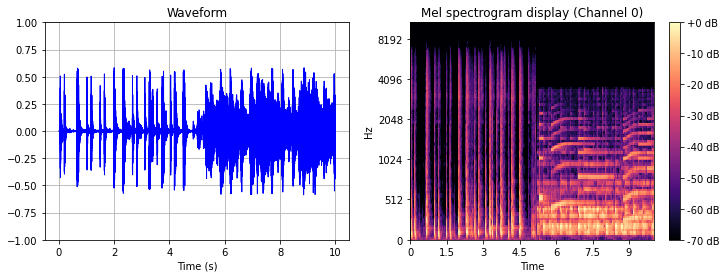

In [ ]:
input, sample_rate = torchaudio.load(fnames_in[ind])
print("sample_rate = ",sample_rate)
show_audio(input, sample_rate)

**Target output audio**

Shape: (1, 441000), Dtype: torch.float32, Duration: 10.0 s
Max:  0.981,  Min: -0.981, Mean:  0.000, Std Dev:  0.356


/home/shawley/.local/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/shawley/.local/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


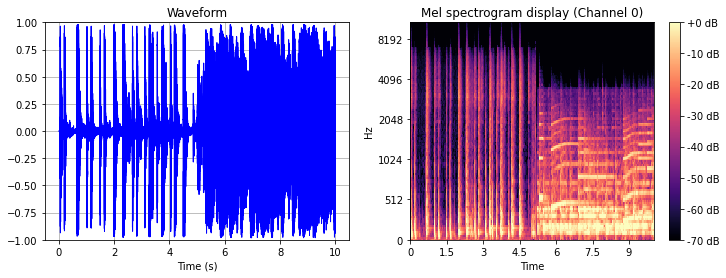

In [ ]:
target, sr_targ = torchaudio.load(fnames_targ[ind])
show_audio(target, sr_targ)

# Dataset class and Dataloaders
Here we modify Christian's SignalTrainLA2ADataset class from [micro-tcn](https://github.com/csteinmetz1/micro-tcn).  See his [data.py](https://github.com/csteinmetz1/micro-tcn/blob/main/microtcn/data.py)


We'll use original dataset class that Christian made, and then for fastai we'll "pack" params and inputs together.
(This will be loading multichannel wav files BTW)

### Adding Positional Encoding
ConvNets and/or MLPs don't necessarily have a sense of position, but giving them one can improve performance on various tasks where position -- such as time alignment -- matters.  Various models will encode position by adding additional channels, e.g. Transformers use Fourier series.  We'll use a simplified scheme that we saw [Francois Fleuret](https://twitter.com/francoisfleuret) use:

In [ ]:
def get_positional_input(seq_length, channel_index=0):
    """scheme taken from Francois Flueret's attentiontoy1.py, 
    cf. https://twitter.com/francoisfleuret/status/1263516788479922176"""
    c = math.ceil(math.log(seq_length) / math.log(2.0))
    positional_input = ((torch.arange(seq_length).unsqueeze(0) // 2**torch.arange(c).unsqueeze(1))%2).float()
    if channel_index==1: positional_input = positional_input.unsqueeze(0)
    return positional_input


def add_positional_encoding(input, channel_index=0):
    "adds channels onto the end of input"
    positional_input = get_positional_input(input.shape[-1], channel_index=channel_index)
    return torch.cat( (input, positional_input), dim=channel_index)

/tmp/ipykernel_1732300/1176972190.py:5: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  positional_input = ((torch.arange(seq_length).unsqueeze(0) // 2**torch.arange(c).unsqueeze(1))%2).float()


6 PE channels for this sequence length.  (Could be more for longer sequences)


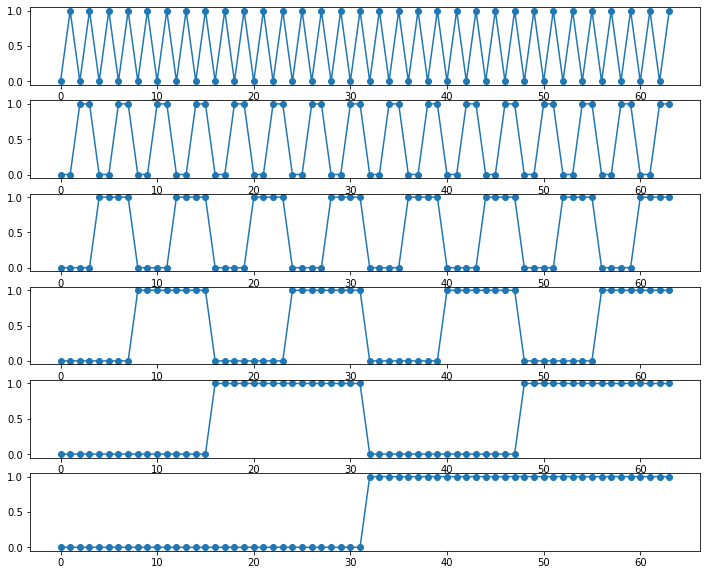

In [ ]:
# quickie test and viz of what the PE scheme actually looks like: ramps up & down with some plateaus
pe = get_positional_input(64)
print(f"{pe.shape[0]} PE channels for this sequence length.  (Could be more for longer sequences)")
fig, ax = plt.subplots(nrows=pe.shape[0], figsize=(12,10))
for c in range(pe.shape[0]):
    ax[c].plot(pe[c,:],'o-')

...you get the idea

In [ ]:
USE_POSITIONAL_ENCODING = False 
REMOVE_TARGET_CLICK = False # just trying this

### Dataset class

In [ ]:
# from our previous notebook 02_etc..
from microtcn.data import SignalTrainLA2ADataset

class SignalTrainLA2ADataset_fastai(SignalTrainLA2ADataset):
    "For fastai's sake, have getitem pack the inputs and params together"
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def __getitem__(self, idx):
        input, target, params = super().__getitem__(idx)
        return torch.cat((input,params),dim=-1), target   # pack input and params together  

In [ ]:
#from microtcn.data import SignalTrainLA2ADataset
# actually we're going to modify Christian's code some so let's rename it...
class TimeAlignDataset(torch.utils.data.Dataset):
    """ SignalTrain LA2A dataset. Source: [10.5281/zenodo.3824876](https://zenodo.org/record/3824876)."""
    def __init__(self, root_dir, subset="train", length=16384, preload=False, half=True, 
                 fraction=1.0, use_soundfile=False, positional_encoding=True):
        """
        Args:
            root_dir (str): Path to the root directory of the SignalTrain dataset.
            subset (str, optional): Pull data either from "train", "val", "test", or "full" subsets. (Default: "train")
            length (int, optional): Number of samples in the returned examples. (Default: 40)
            preload (bool, optional): Read in all data into RAM during init. (Default: False)
            half (bool, optional): Store the float32 audio as float16. (Default: True)
            fraction (float, optional): Fraction of the data to load from the subset. (Default: 1.0)
            use_soundfile (bool, optional): Use the soundfile library to load instead of torchaudio. (Default: False)
        """
        self.root_dir = root_dir
        self.subset = subset
        self.length = length
        self.preload = preload
        self.half = half
        self.fraction = fraction
        self.use_soundfile = use_soundfile
        self.positional_channels, self.positional_input  = 0, None
        if positional_encoding:
            self.positional_input = get_positional_input(length)  # same PE tensor for all time
            self.positional_channels = self.positional_input.shape[1]
            print("self.positional_input.shape = ",self.positional_input.shape)

        if self.subset == "full":
            self.target_files = glob.glob(os.path.join(self.root_dir, "**", "target_*.wav"))
            self.input_files  = glob.glob(os.path.join(self.root_dir, "**", "input_*.wav"))
        else:
            # get all the target files files in the directory first
            self.target_files = glob.glob(os.path.join(self.root_dir, self.subset.capitalize(), "target_*.wav"))
            self.input_files  = glob.glob(os.path.join(self.root_dir, self.subset.capitalize(), "input_*.wav"))

        self.examples = [] 
        self.minutes = 0  # total number of hours of minutes in the subset

        # ensure that the sets are ordered correctlty
        self.target_files.sort()
        self.input_files.sort()

        # get the parameters
        param_parse_fns = [x.replace("__pb_dist","") for x in self.target_files]
        self.params = [(float(f.split("__")[1].replace(".wav","")), float(f.split("__")[2].replace(".wav",""))) for f in param_parse_fns]
        
        # loop over files to count total length
        for idx, (tfile, ifile, params) in enumerate(zip(self.target_files, self.input_files, self.params)):

            ifile_id = int(os.path.basename(ifile).split("_")[1])
            tfile_id = int(os.path.basename(tfile).split("_")[1])
            if ifile_id != tfile_id:
                raise RuntimeError(f"Found non-matching file ids: {ifile_id} != {tfile_id}! Check dataset.")

            md = torchaudio.info(tfile)
            num_frames = md.num_frames

            if self.preload:
                sys.stdout.write(f"* Pre-loading... {idx+1:3d}/{len(self.target_files):3d} ...\r")
                sys.stdout.flush()
                input, sr  = self.load(ifile)
                target, sr = self.load(tfile)

                num_frames = int(np.min([input.shape[-1], target.shape[-1]]))
                if input.shape[-1] != target.shape[-1]:
                    print(os.path.basename(ifile), input.shape[-1], os.path.basename(tfile), target.shape[-1])
                    raise RuntimeError("Found potentially corrupt file!")
                    
                if self.positional_input is not None: input = torch.cat((input, self.positional_input), dim=1)

                if self.half:
                    input = input.half()
                    target = target.half()
            else:
                input = None
                target = None

            # create one entry for each patch
            self.file_examples = []
            for n in range((num_frames // self.length)):
                offset = int(n * self.length)
                end = offset + self.length
                #print("idx, params = ",idx,params)
                self.file_examples.append({"idx": idx, 
                                           "target_file" : tfile,
                                           "input_file" : ifile,
                                           "input_audio" : input[:,offset:end] if input is not None else None,
                                           "target_audio" : target[:,offset:end] if input is not None else None,
                                           "params" : params,
                                           "offset": offset,
                                           "frames" : num_frames})

            # add to overall file examples
            self.examples += self.file_examples
        
        # use only a fraction of the subset data if applicable
        if self.subset == "train":
            classes = set([ex['params'] for ex in self.examples])
            print("classes = ",classes)
            n_classes = len(classes) # number of unique compressor configurations
            fraction_examples = int(len(self.examples) * self.fraction)
            n_examples_per_class = int(fraction_examples / n_classes)
            n_min_total = ((self.length * n_examples_per_class * n_classes) / md.sample_rate) / 60 
            n_min_per_class = ((self.length * n_examples_per_class) / md.sample_rate) / 60 
            print(sorted(classes))
            print(f"Total Examples: {len(self.examples)}     Total classes: {n_classes}")
            print(f"Fraction examples: {fraction_examples}    Examples/class: {n_examples_per_class}")
            print(f"Training with {n_min_per_class:0.2f} min per class    Total of {n_min_total:0.2f} min")

            if n_examples_per_class <= 0: 
                raise ValueError(f"Fraction `{self.fraction}` set too low. No examples selected.")

            sampled_examples = []

            for config_class in classes: # select N examples from each class
                class_examples = [ex for ex in self.examples if ex["params"] == config_class]
                example_indices = np.random.randint(0, high=len(class_examples), size=n_examples_per_class)
                class_examples = [class_examples[idx] for idx in example_indices]
                extra_factor = int(1/self.fraction)
                sampled_examples += class_examples * extra_factor

            self.examples = sampled_examples

        self.minutes = ((self.length * len(self.examples)) / md.sample_rate) / 60 

        # we then want to get the input files
        print(f"Located {len(self.examples)} examples totaling {self.minutes:0.2f} min in the {self.subset} subset.")

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        if self.preload:
            audio_idx = self.examples[idx]["idx"]
            offset = self.examples[idx]["offset"]
            input = self.examples[idx]["input_audio"]
            target = self.examples[idx]["target_audio"]
        else:
            offset = self.examples[idx]["offset"] 
            input, sr  = torchaudio.load(self.examples[idx]["input_file"], 
                                        num_frames=self.length, 
                                        frame_offset=offset, 
                                        normalize=False)
            #print("input.shape, self.positional_input.shape =",input.shape, self.positional_input.shape)
            if self.positional_input is not None: input = torch.cat((input, self.positional_input), dim=0)

            
            target, sr = torchaudio.load(self.examples[idx]["target_file"], 
                                        num_frames=self.length, 
                                        frame_offset=offset, 
                                        normalize=False)
            target = target[REMOVE_TARGET_CLICK:,:]
            
            if self.half:
                input = input.half()
                target = target.half()

        # at random with p=0.5 flip the phase 
        if np.random.rand() > 0.5:
            input[1:,:-self.positional_channels] = -input[1:,:-self.positional_channels]   # but don't flip the click or PE
            target[1:,:-self.positional_channels] = -target[1:,:-self.positional_channels] 

        # then get the tuple of parameters
        params = torch.tensor(self.examples[idx]["params"]).unsqueeze(0)
        params[:,1] /= 100

        #print(f"Checking: idx = {idx}, input.shape = {input.shape}, target.shape = {target.shape}, params.shape = {params.shape}")
        
        return input, target, params

    def load(self, filename):
        if self.use_soundfile:
            x, sr = sf.read(filename, always_2d=True)
            x = torch.tensor(x.T)
        else:
            x, sr = torchaudio.load(filename, normalize=True) #False), true for pedalboard out
        return x, sr
    
    
    
class TimeAlignDataset_fastai(TimeAlignDataset):
    "For fastai's sake, have getitem pack the inputs and params together"
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def __getitem__(self, idx):
        input, target, params = super().__getitem__(idx)
        #print(f"Checking: idx = {idx}, input.shape = {input.shape}, params.shape = {params.shape}")
        if input.shape[0] > params.shape[0]:  # this is an artifact of our trying to pack things together
            #print("trying to fix...")
            params = torch.tile(params, (input.shape[0],1))
            #print(f"Checking2: idx = {idx}, input.shape = {input.shape}, params.shape = {params.shape}\n")
        return torch.cat((input,params),dim=-1), target   # pack input and params together

In [ ]:
class Args(object):  # stand-in for parseargs. these are all micro-tcn defaults
    model_type ='tcn'
    root_dir = str(path)
    preload = False
    sample_rate = 44100
    shuffle = True
    train_subset = 'train'
    val_subset = 'val'
    train_length = 65536
    train_fraction = 1.0
    eval_length = train_length # 65536
    batch_size = 8   # original is 32, my laptop needs smaller, esp. w/o half precision
    num_workers = 4  # 1 for debugging, 4 for normal usage 
    precision = 32  # LEAVE AS 32 FOR NOW: HALF PRECISION (16) NOT WORKING YET -SHH
    n_params = 2
    
args = Args()

# just re-measure input and target sizes in case something changed in the REPL/Juptyer notebook state
input, sample_rate = torchaudio.load(fnames_in[ind])
target, sr_targ = torchaudio.load(fnames_targ[ind])

USER_INPUT_CHANNELS = input.shape[0]         # how many were supplied by the user, how many we'll plot
TOTAL_INPUT_CHANNELS = input.shape[0]
TARGET_OUTPUT_CHANNELS = target.shape[0]

if USE_POSITIONAL_ENCODING:
    pe = get_positional_input(args.train_length)
    print("pe.shape =",pe.shape)
    TOTAL_INPUT_CHANNELS = USER_INPUT_CHANNELS + pe.shape[0]    # how many the model will take
    
print(f"USER_INPUT_CHANNELS = {USER_INPUT_CHANNELS}") 
print(f"TOTAL_INPUT_CHANNELS = {TOTAL_INPUT_CHANNELS}")
print(f"TARGET_OUTPUT_CHANNELS = {TARGET_OUTPUT_CHANNELS}")

#if args.precision == 16:  torch.set_default_dtype(torch.float16)

# setup the dataloaders
train_dataset = SignalTrainLA2ADataset_fastai(args.root_dir, 
                    subset=args.train_subset, 
                    fraction=args.train_fraction,
                    half=True if args.precision == 16 else False, 
                    preload=args.preload, 
                    length=args.train_length)

train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                    shuffle=args.shuffle,
                    batch_size=args.batch_size,
                    num_workers=args.num_workers,
                    pin_memory=True)

val_dataset = SignalTrainLA2ADataset_fastai(args.root_dir, 
                    preload=args.preload,
                    half=True if args.precision == 16 else False,
                    subset=args.val_subset,
                    length=args.eval_length)

val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                    shuffle=False,
                    batch_size=args.batch_size,
                    num_workers=args.num_workers,
                    pin_memory=True)

USER_INPUT_CHANNELS = 1
TOTAL_INPUT_CHANNELS = 1
TARGET_OUTPUT_CHANNELS = 1
[(1.0, 6.0), (1.0, 12.0), (1.0, 18.0), (1.0, 24.0), (1.0, 30.0)]
Total Examples: 396     Total classes: 5
Fraction examples: 396    Examples/class: 79
Training with 1.96 min per class    Total of 9.78 min
Located 395 examples totaling 9.78 min in the train subset.
Located 90 examples totaling 2.23 min in the val subset.


If the user requested fp16 precision then we need to install NVIDIA apex:

In [ ]:
if False and args.precision == 16:
    %pip install -q --disable-pip-version-check --no-cache-dir git+https://github.com/NVIDIA/apex
    from apex.fp16_utils import convert_network

### Define the model(s)
Christian defined a lot of models. We'll do the TCN-300 ~~and the LSTM~~. 

In [ ]:
#from microtcn.tcn_bare import TCNModel as TCNModel
#from microtcn.lstm import LSTMModel # actually the LSTM depends on a lot of Lightning stuff, so we'll skip that
from microtcn.utils import center_crop, causal_crop

# this is all exactly Christian's code except one tiny change in "groups=" for self.res in TCNBlock. 

class FiLM(torch.nn.Module):
    def __init__(self, 
                 num_features, 
                 cond_dim):
        super(FiLM, self).__init__()
        self.num_features = num_features
        self.bn = torch.nn.BatchNorm1d(num_features, affine=False)
        self.adaptor = torch.nn.Linear(cond_dim, num_features * 2)

    def forward(self, x, cond):

        cond = self.adaptor(cond)
        g, b = torch.chunk(cond, 2, dim=-1)
        g = g.permute(0,2,1)
        b = b.permute(0,2,1)

        x = self.bn(x)      # apply BatchNorm without affine
        x = (x * g) + b     # then apply conditional affine

        return x

class TCNBlock(torch.nn.Module):
    def __init__(self, 
                in_ch, 
                out_ch, 
                kernel_size=3, 
                padding=0, 
                dilation=1, 
                grouped=False, 
                conditional=False, 
                **kwargs):
        super(TCNBlock, self).__init__()

        self.in_ch = in_ch
        self.out_ch = out_ch
        self.kernel_size = kernel_size
        self.padding = padding
        self.dilation = dilation
        self.grouped = grouped
        self.conditional = conditional

        groups = out_ch if grouped and (in_ch % out_ch == 0) else 1
        
        self.conv1 = torch.nn.Conv1d(in_ch, 
                                     out_ch, 
                                     kernel_size=kernel_size, 
                                     padding=padding, 
                                     dilation=dilation,
                                     groups=groups,
                                     bias=False)
        #if grouped:
        #    self.conv1b = torch.nn.Conv1d(out_ch, out_ch, kernel_size=1)

        if conditional:
            self.film = FiLM(out_ch, 32)
        else:
            self.bn = torch.nn.BatchNorm1d(out_ch)

        self.relu = torch.nn.PReLU(out_ch)
        self.res = torch.nn.Conv1d(in_ch, 
                                   out_ch, 
                                   kernel_size=1,
                                   groups=groups, # SHH: this is a change; Christian's original read =in_ch here. 
                                   bias=False)

    def forward(self, x: torch.Tensor, p: torch.Tensor) -> torch.Tensor:
        x_in = x        
        x = self.conv1(x)
        #if self.grouped: # apply pointwise conv
        #    x = self.conv1b(x)
        if p is not None:   # apply FiLM conditioning
            x = self.film(x, p)
        else:
            x = self.bn(x)
        x = self.relu(x)

        x_res = self.res(x_in)
        x = x + center_crop(x_res, x.size(-1))

        return x

class TCNModel(torch.nn.Module):
    """ Temporal convolutional network with conditioning module.

        Args:
            nparams (int): Number of conditioning parameters.
            ninputs (int): Number of input channels (mono = 1, stereo 2). Default: 1
            noutputs (int): Number of output channels (mono = 1, stereo 2). Default: 1
            nblocks (int): Number of total TCN blocks. Default: 10
            kernel_size (int): Width of the convolutional kernels. Default: 3
            dialation_growth (int): Compute the dilation factor at each block as dilation_growth ** (n % stack_size). Default: 1
            channel_growth (int): Compute the output channels at each black as in_ch * channel_growth. Default: 2
            channel_width (int): When channel_growth = 1 all blocks use convolutions with this many channels. Default: 64
            stack_size (int): Number of blocks that constitute a single stack of blocks. Default: 10
            grouped (bool): Use grouped convolutions to reduce the total number of parameters. Default: False
            num_examples (int): Number of evaluation audio examples to log after each epochs. Default: 4
        """
    def __init__(self, 
                 nparams,
                 ninputs=1,
                 noutputs=1,
                 nblocks=10, 
                 kernel_size=3, 
                 dilation_growth=1, 
                 channel_growth=1, 
                 channel_width=32, 
                 stack_size=10,
                 grouped=False,
                 num_examples=4,
                 save_dir=None,
                 **kwargs):
        super(TCNModel, self).__init__()

        self.nparams=nparams
        self.ninputs=ninputs
        self.noutputs=noutputs
        self.nblocks=nblocks
        self.kernel_size=kernel_size
        self.dilation_growth=dilation_growth
        self.channel_growth=channel_growth
        self.channel_width=channel_width
        self.stack_size=stack_size
        self.grouped=grouped
        self.num_examples=num_examples
        self.save_dir=save_dir

        # setup loss functions
        self.l1      = torch.nn.L1Loss()

        print("nparams = ",nparams)
        if self.nparams > 0:
            self.gen = torch.nn.Sequential(
                torch.nn.Linear(nparams, 16),
                torch.nn.ReLU(),
                torch.nn.Linear(16, 32),
                torch.nn.ReLU(),
                torch.nn.Linear(32, 32),
                torch.nn.ReLU()
            )

        self.blocks = torch.nn.ModuleList()
        for n in range(nblocks):
            in_ch = out_ch if n > 0 else ninputs
            
            if self.channel_growth > 1:
                out_ch = in_ch * self.channel_growth 
            else:
                out_ch = self.channel_width

            dilation = self.dilation_growth ** (n % self.stack_size)
            #dilation = dilation_growth
            self.blocks.append(TCNBlock(in_ch, 
                                        out_ch, 
                                        kernel_size=self.kernel_size, 
                                        dilation=dilation,
                                        grouped=self.grouped,
                                        conditional=True if self.nparams > 0 else False))

        self.output = torch.nn.Conv1d(out_ch, noutputs, kernel_size=1)

    def forward(self, x, p=None):
        # if parameters present, 
        # compute global conditioning
        #print("TCNModel.forward: x.shape = ",x.shape)
        if p is not None:
            cond = self.gen(p)
        else:
            cond = None

        # iterate over blocks passing conditioning
        for idx, block in enumerate(self.blocks):
            x = block(x, cond)
            if idx == 0:
                skips = x
            else:
                skips = center_crop(skips, x.size(-1))
                skips = skips + x

        return torch.tanh(self.output(x + skips))

    def compute_receptive_field(self):
        """ Compute the receptive field in samples."""
        rf = self.kernel_size
        for n in range(1,self.nblocks):
            dilation = self.dilation_growth ** (n % self.stack_size)
            rf = rf + ((self.kernel_size-1) * dilation)
        return rf


In [ ]:
class TCNModel_fastai(TCNModel):
    "For fastai's sake, unpack the inputs and params"
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def forward(self, x, p=None):
        if (p is None) and (self.nparams > 0):  # unpack the params if needed
            assert len(list(x.size())) == 3   # sanity check 
            x, p = x[:,:,0:-self.nparams], x[:,:,-self.nparams:]
            if p.shape[1] > 1:
                p = p[:,0:1,:]  # only need one copy of params, not the stacked copies supplied by DL. 
        return super().forward(x, p=p)

In [ ]:
#show
# micro-tcn defines several different model configurations. I just chose one of them. 
train_configs = [
      {"name" : "TCN-300",
     "model_type" : "tcn",
     "nblocks" : 10,
     "dilation_growth" : 2,
     "kernel_size" : 15,
     "causal" : False,
     "train_fraction" : 1.00,
     "batch_size" : args.batch_size
    }
]

print(f"USER_INPUT_CHANNELS = {USER_INPUT_CHANNELS}") 
print(f"TOTAL_INPUT_CHANNELS = {TOTAL_INPUT_CHANNELS}")
print(f"TARGET_OUTPUT_CHANNELS = {TARGET_OUTPUT_CHANNELS}")

dict_args = train_configs[0]
dict_args["channel_width"] = 32
dict_args["nparams"] = 2
dict_args["ninputs"] = TOTAL_INPUT_CHANNELS  # number of input channels
dict_args["noutputs"] = TARGET_OUTPUT_CHANNELS  # number of output channels
dict_args["grouped"] = False 

model = TCNModel_fastai(**dict_args)
dtype = torch.float32

USER_INPUT_CHANNELS = 1
TOTAL_INPUT_CHANNELS = 1
TARGET_OUTPUT_CHANNELS = 1
nparams =  2


Let's take a look at the model:

In [ ]:
#show
# this summary allows one to compare the original TCNModel with the TCNModel_fastai
if type(model) == TCNModel_fastai:
    torchsummary.summary(model, [(TOTAL_INPUT_CHANNELS,args.train_length)], device="cpu")
else:
    torchsummary.summary(model, [(TOTAL_INPUT_CHANNELS,args.train_length),(1,2)], device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 16]              48
              ReLU-2                [-1, 1, 16]               0
            Linear-3                [-1, 1, 32]             544
              ReLU-4                [-1, 1, 32]               0
            Linear-5                [-1, 1, 32]           1,056
              ReLU-6                [-1, 1, 32]               0
            Conv1d-7            [-1, 32, 65520]             480
            Linear-8                [-1, 1, 64]           2,112
       BatchNorm1d-9            [-1, 32, 65520]               0
             FiLM-10            [-1, 32, 65520]               0
            PReLU-11            [-1, 32, 65520]              32
           Conv1d-12            [-1, 32, 65534]              32
         TCNBlock-13            [-1, 32, 65520]               0
           Conv1d-14            [-1, 32

### Getting the model into fastai form

Zach Mueller made a very helpful [fastai_minima](https://muellerzr.github.io/fastai_minima/) package that we'll use, and follow his instructions.  

> **TODO:** Zach says I should either use `fastai` or `fastai_minima`, not mix them like I'm about to do. But what I have below is the only thing that *works* right now. ;-) 

In [ ]:
#show
# I guess we could've imported these up at the top of the notebook...
from torch import optim
from fastai_minima.optimizer import OptimWrapper
#from fastai_minima.learner import Learner  # this doesn't include lr_find()
from fastai.learner import Learner
from fastai_minima.learner import DataLoaders
#from fastai_minima.callback.training_utils import CudaCallback, ProgressCallback # note sure if I need these

In [ ]:
def opt_func(params, **kwargs): return OptimWrapper(optim.SGD(params, **kwargs))

dls = DataLoaders(train_dataloader, val_dataloader)

### Checking Dataloaders

In [ ]:
if args.precision==16: 
    dtype = torch.float16
    model = convert_network(model, torch.float16)

model = model.to('cuda:0')
if type(model) == TCNModel_fastai:
    print("We're using Hawley's modified code")
    packed, targ = dls.one_batch()
    print("packed.shape, targ.shape =",packed.shape, targ.shape)
    inp, params = packed[:,:,0:-dict_args['nparams']], packed[:,:,-dict_args['nparams']:]
    pred = model.forward(packed.to('cuda:0', dtype=dtype))
else:
    print("We're using Christian's version of Dataloader and model")
    inp, targ, params = dls.one_batch()
    pred = model.forward(inp.to('cuda:0',dtype=dtype), p=params.to('cuda:0', dtype=dtype))
print(f"input  = {inp.size()}\ntarget = {targ.size()}\nparams = {params.size()}\npred   = {pred.size()}")

We're using Hawley's modified code
packed.shape, targ.shape = torch.Size([8, 1, 65538]) torch.Size([8, 1, 65536])
input  = torch.Size([8, 1, 65536])
target = torch.Size([8, 1, 65536])
params = torch.Size([8, 1, 2])
pred   = torch.Size([8, 1, 51214])


We can make the pred and target the same length by cropping when we compute the loss:

In [ ]:
class Crop_Loss:
    "Crop target size to match preds"
    def __init__(self, axis=-1, causal=False, reduction="mean", func=nn.L1Loss):
        store_attr()
        self.loss_func = func()
    def __call__(self, pred, targ):
        targ = causal_crop(targ, pred.shape[-1]) if self.causal else center_crop(targ, pred.shape[-1])
        #pred, targ = TensorBase(pred), TensorBase(targ)
        assert pred.shape == targ.shape, f'pred.shape = {pred.shape} but targ.shape = {targ.shape}'
        return self.loss_func(pred,targ).flatten().mean() if self.reduction == "mean" else loss(pred,targ).flatten().sum()
    

# we could add a metric like MSE if we want
def crop_mse(pred, targ, causal=False): 
    targ = causal_crop(targ, pred.shape[-1]) if causal else center_crop(targ, pred.shape[-1])
    return ((pred - targ)**2).mean()

#### Enable logging with WandB:

In [ ]:
wandb.login()

wandb: Currently logged in as: drscotthawley (use `wandb login --relogin` to force relogin)


True

## Define the fastai Learner and callbacks

We're going to add a new custom WandBAudio callback futher below, that we'll uses when we call `fit()`.

#### WandBAudio Callback
In order to log audio samples, let's write our own audio-logging callback for fastai:

In [ ]:
class WandBAudio(Callback):
    """Progress-like callback: log audio to WandB"""
    order = ProgressCallback.order+1
    def __init__(self, n_preds=5, sample_rate=44100):
        store_attr()

    def after_epoch(self):  
        if not self.learn.training:
            with torch.no_grad():
                preds, targs = [x.detach().cpu().numpy().copy() for x in [self.learn.pred, self.learn.y]]
            log_dict = {}
            for i in range(min(self.n_preds, preds.shape[0])): # note wandb only supports mono
                    log_dict[f"preds_{i}"] = wandb.Audio(preds[i,0,:], caption=f"preds_{i}", sample_rate=self.sample_rate)
            wandb.log(log_dict)

#### Learner and wandb init

In [ ]:
wandb.init(project='distortion')#  no name, name=json.dumps(dict_args))

learn = Learner(dls, model, loss_func=Crop_Loss(), metrics=crop_mse, opt_func=opt_func,
               cbs= [WandbCallback()])

wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


## Train the model

We can use the fastai learning rate finder to suggest a learning rate:

SuggestedLRs(valley=0.0073514278046786785)

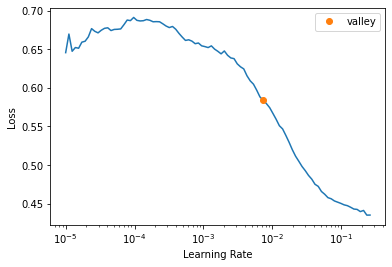

In [ ]:
learn.lr_find(start_lr=1e-5, end_lr=0.5) 

And now we'll train using the one-cycle LR schedule, with the WandBAudio callback. (Ignore any warning messages)

In [ ]:
epochs = 50 
learn.fit_one_cycle(epochs, lr_max=7e-3, cbs=WandBAudio(sample_rate=args.sample_rate))
# ignore WandbCallback warnings that follow 

Could not gather input dimensions
WandbCallback requires use of "SaveModelCallback" to log best model
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 


epoch,train_loss,valid_loss,crop_mse,time
0,0.407489,0.297916,0.173998,00:06
1,0.264681,0.176574,0.061988,00:06
2,0.209961,0.163446,0.053938,00:06
3,0.184577,0.154900,0.049041,00:06
4,0.167748,0.184173,0.061744,00:06
5,0.160524,0.138373,0.041212,00:06
6,0.142673,0.122534,0.029787,00:06
7,0.119197,0.159572,0.045898,00:06
8,0.102188,0.178910,0.059493,00:06
9,0.087986,0.128726,0.033173,00:06


In [ ]:
wandb.finish() # call wandb.finish() after training or your logs may be incomplete

crop_mse,0.00032
dampening_0,0
epoch,50
lr_0,0.0
mom_0,0.95
nesterov_0,False
raw_loss,0.02742
train_loss,0.0207
valid_loss,0.01011
wd_0,0


crop_mse,█▃▃▃▃▂▃▃▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
dampening_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr_0,▁▁▂▃▄▅▆▇▇██████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▇▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
nesterov_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
raw_loss,█▄▄▃▂▄▃▂▂▂▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▅▅▅▄▄▅▅▂▂▂▃▃▃▂▂▂▂▁▂▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [ ]:
learn.save('distortion')

Path('models/distortion.pth')

Go check out the resulting run logs, graphs, and audio samples at https://wandb.ai/drscotthawley/micro-tcn-fastai, or...
lemme see if I can embed some results below:

## Inference / Evaluation 

Load in the testing data

In [ ]:
test_dataset = SignalTrainLA2ADataset_fastai(args.root_dir, 
                    preload=args.preload,
                    half=True if args.precision == 16 else False,
                    subset='test',
                    length=args.eval_length)

test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                    shuffle=False,
                    batch_size=args.batch_size,
                    num_workers=args.num_workers,
                    pin_memory=True)

learn = Learner(dls, model, loss_func=Crop_Loss(), metrics=crop_mse, opt_func=opt_func, cbs=[])
learn.load('distortion')

Located 18 examples totaling 0.45 min in the test subset.


In [ ]:
!ls {path}/Test

input_235_.wav	input_259_.wav	       target_256__1__30.wav
input_256_.wav	target_235__1__12.wav  target_259__1__18.wav


Let's get some predictions from the model. Note that the length of these predictions will greater than in training, because we specified them differently:

In [ ]:
print(args.train_length, args.eval_length)

65536 65536


Handy routine to grab some data and run it through the model to get predictions:

In [ ]:
def get_pred_batch(dataloader, crop_them=True, causal=False):
    packed, target = next(iter(dataloader))
    input, params = packed[:,:,0:-dict_args['nparams']], packed[:,:,-dict_args['nparams']:]
    pred = model.forward(packed.to('cuda:0', dtype=dtype))
    print("pred.shape = ",pred.shape)
    if crop_them: 
        target = causal_crop(target, pred.shape[-1]) if causal else center_crop(target, pred.shape[-1])
        input = causal_crop(input, pred.shape[-1]) if causal else center_crop(input, pred.shape[-1])
    input, params, target, pred = [x.detach().cpu() for x in [input, params, target, pred]]
    return input, params, target, pred

pred.shape =  torch.Size([8, 1, 51214])
------- i = 3 ---------

input:
Shape: (1, 51214), Dtype: torch.float32, Duration: 1.1613151927437642 s
Max:  0.271,  Min: -0.360, Mean: -0.000, Std Dev:  0.072


/home/shawley/.local/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/shawley/.local/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


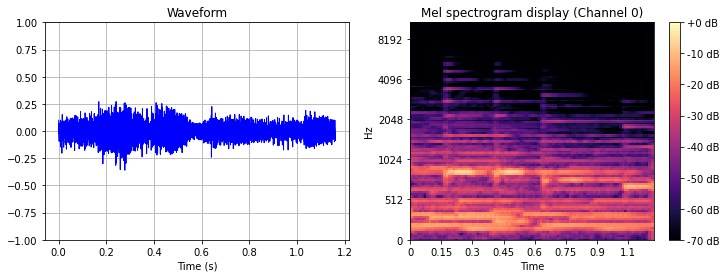

In [ ]:
input, params, target, pred = get_pred_batch(test_dataloader, causal=dict_args['causal'])
i = np.random.randint(input.shape[0])  # just look at the first element
print(f"------- i = {i} ---------\n")
print(f"input:")
show_audio(input[i][:USER_INPUT_CHANNELS], sample_rate)  # don't show positional encoding

target:
Shape: (1, 51214), Dtype: torch.float32, Duration: 1.1613151927437642 s
Max:  0.793,  Min: -0.892, Mean:  0.000, Std Dev:  0.266


/home/shawley/.local/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/shawley/.local/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


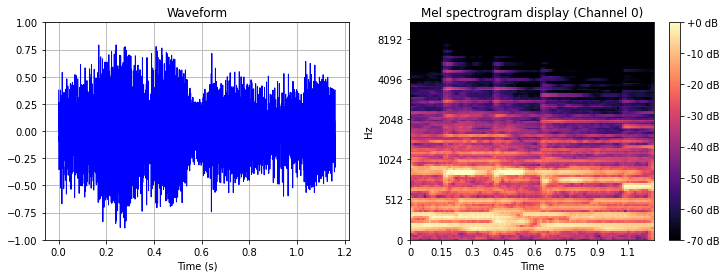

In [ ]:
print(f"target:")
show_audio(target[i], sample_rate)

prediction:
Shape: (1, 51214), Dtype: torch.float32, Duration: 1.1613151927437642 s
Max:  0.761,  Min: -0.869, Mean: -0.000, Std Dev:  0.258


/home/shawley/.local/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/shawley/.local/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


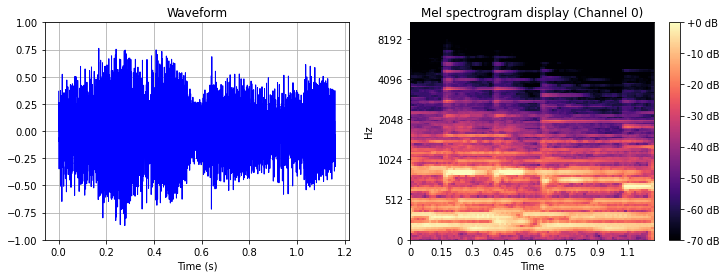

In [ ]:
print(f"prediction:")
show_audio(pred[i], sample_rate)

Hmmm... seems to be predicting all zeros, which means it's not learning